In [1]:
size=256
overl=0.5
epochs=1
modelname="model3_256_revamped"
batchsize=20
learning_rate = (10**(-4))*1.5
training=False
resume_training=True
base='/mnt/z9-slide-storage/VipsML'
origs=[base+'/00-orig.tif']
masks=[base+'/00-mask.tif']

In [2]:

from keras.utils import Sequence
import pyvips as Vips
from random import shuffle, choice
from numpy import rot90, flip, frombuffer, uint8, asarray, squeeze
from math import ceil, floor
from functools import reduce

class SegNetImage(Sequence):    
    """Generator class to be fed to a keras fit-function."""

    def __init__(self,imagePath,maskpath=None,frame=256,overlay=0.0, batchSize=10):
        """Args:
            imagePath: Path to original image.
            maskpath: Path to image masks, None if not training.
            frame: Frame size (x and y dim)
            overlay: How much overlay to keep between each piece of the image.
            batchSize: Batchsize for feeding into CNN."""
        
        self.orig=Vips.Image.new_from_file(imagePath)        
        h,w,d = self.orig.width, self.orig.height, self.orig.bands        
        self.origShape = (w,h,d)
        self.frame=frame
        self.overlay=round(self.frame*overlay)
        self.step = self.frame-self.overlay        
        self.batchSize=batchSize                
        
        #The last step will cover a whole frame
        self.x_frames=ceil((w-(self.frame-self.step))/(self.step))
        self.y_frames=ceil((h-(self.frame-self.step))/(self.step))        
        self.total_frames=self.x_frames*self.y_frames
        
        # Fix padding 
        _w = ceil(self.x_frames*self.step)+(self.frame-self.step)
        _h = ceil(self.y_frames*self.step)+(self.frame-self.step)
        self.embeddedShape = (_w, _h, d)
        self.orig=self.orig.embed(0,0,_w,_h,extend='white')    
                
        if maskpath == None:
            self.training=False
        else:
            self.training=True
            self.initMask(maskpath)
            self.frame_order = list(range(self.total_frames))
            # The fit function will randomize the batch order,
            # but not the individual datasets inside each batch:
            shuffle(self.frame_order)
        
    def initMask(self,maskpath):
        self.mask=Vips.Image.new_from_file(maskpath)
        self.mask=self.mask.embed(0,0,self.embeddedShape[0],self.embeddedShape[1],extend='black')
        # We need a binary class matrix for training.
        # We could use keras.utils.to_categorical downstream instead.
        self.featureN = int(self.mask.max()+1)
        features=list(range(self.featureN))
        expanded = None
        for f in features:
            if expanded:
                expanded=expanded.bandjoin(self.mask==f)
            else:
                expanded = self.mask==f
        self.mask=expanded  
        
    def __len__(self):
        return int(ceil(self.total_frames/self.batchSize))
    
    def __getitem__(self,index):
        # the keras.utils.Sequence expects one batch upon requesting an item
        start = index*self.batchSize
        end = min((index+1)*(self.batchSize),self.total_frames)
        if self.training:
            origs = []
            masks = []
            # We iterate one by one to assign random rotation and flipping
            # to both image and mask
            for i in self.frame_order[start:end]:
                rot=choice(range(4))
                flippage=choice(range(2))==1
                origs += [self.getSingleItem(i,rot,flippage)]
                # Output vector is expected to be 1D (could be fixed in the model definition):
                masks += [self.getMask(i,rot,flippage).reshape((self.frame*self.frame,self.featureN))]
            return asarray(origs),asarray(masks).astype(float)
        else:
            return asarray([self.getSingleItem(i) for i in range(start,end)])
    
    def getSingleItem(self,index,rot=0,flp=False):
        rotations=[lambda x: x,lambda x: x.rot90(), lambda x: x.rot180(), lambda x: x.rot270()]
        y = floor(index/self.x_frames)
        x = index % self.x_frames
        x_px = x*(self.step)
        y_px = y*(self.step)
        o=self.getImageAt(x_px, y_px, self.frame)
        o=rotations[rot](o)
        if flp:
            o=o.fliphor()
        return self.toNp(o)
        
    def getMask(self,index,rot=0,flp=False):
        rotations=[lambda x: x,lambda x: x.rot90(), lambda x: x.rot180(), lambda x: x.rot270()]
        y = floor(index/self.x_frames)
        x = index % self.x_frames
        x_px = x*(self.step)
        y_px = y*(self.step)
        o=self.getImageAt(x_px,y_px,self.frame,im=self.mask)
        o=rotations[rot](o)
        if flp:
            o=o.fliphor()
        return self.toNp(o)

    def getShape(self):
        return (self.frame, self.frame, 3)
        
    def toNp(self,im):
        return frombuffer(im.write_to_memory(), dtype=uint8).reshape(im.width, im.height, im.bands)
     
    def getBoxFrom(self,x,y,w):
        return (x,y,x+w,y+w)

    def getImageAt(self,x,y,w,im=None):
        if im is None:
          im=self.orig
        return im.crop(x,y,w,w)

    def setBatchSize(self,n):
        self.batchSize=n
    
    def on_epoch_end(self):
        # re-randomize upon finishing an epoch
        shuffle(self.frame_order)

class MultiSegNetImage(Sequence):
    def __init__(self,origs,masks=None,frame=256,overlay=0.0, batchSize=10):
        self.frame=frame
        self.overlay=overlay
        self.batchSize=batchSize
        self.training = masks!=None
        self.images = [SegNetImage(origs[i],masks[i] if self.training else None,frame,overlay,batchSize) for i in range(len(origs))]
        self.indices = reduce(lambda acc, val: acc+[(val,i) for i in range(self.images[val].total_frames)],range(len(self.images)),[])
        shuffle(self.indices)
    
    def getShape(self):
        """ Peek ahead at first image in stack"""
        return self.images[0].getShape()
    
    def totalItems(self):
        """ Total number of items """
        return len(self.indices)
        
    def __len__(self):
        """ Number of batches, not items """
        return int(ceil(self.totalItems()/self.batchSize))
    
    def __getitem__(self,index):
        """ One batch, not one item """
        start = index*self.batchSize
        end = min((index+1)*(self.batchSize),self.totalItems())
        if self.training:
            origs = []
            masks = []
            # We iterate one by one to assign (same) random rotation
            # and flipping to both image and mask
            for entry in self.indices[start:end]:
                imageN,itemN = entry
                image=self.images[imageN]
                rot=choice(range(4))
                flippage=choice(range(2))==1
                origs += [image.getSingleItem(itemN,rot,flippage)]
                # Output vector is expected to be 1D (could be fixed in the model definition):
                masks += [image.getMask(itemN,rot,flippage).reshape((image.frame*image.frame,image.featureN))]
            return asarray(origs),asarray(masks).astype(float)
        else:
            return asarray([self.images[i].getSingleItem(n) for i,n in indices[start:end]])
        
    def on_epoch_end(self):
        # re-randomize upon finishing an epoch
        shuffle(self.indices)
            



Using TensorFlow backend.


Build encoder done..
Build decoder done..


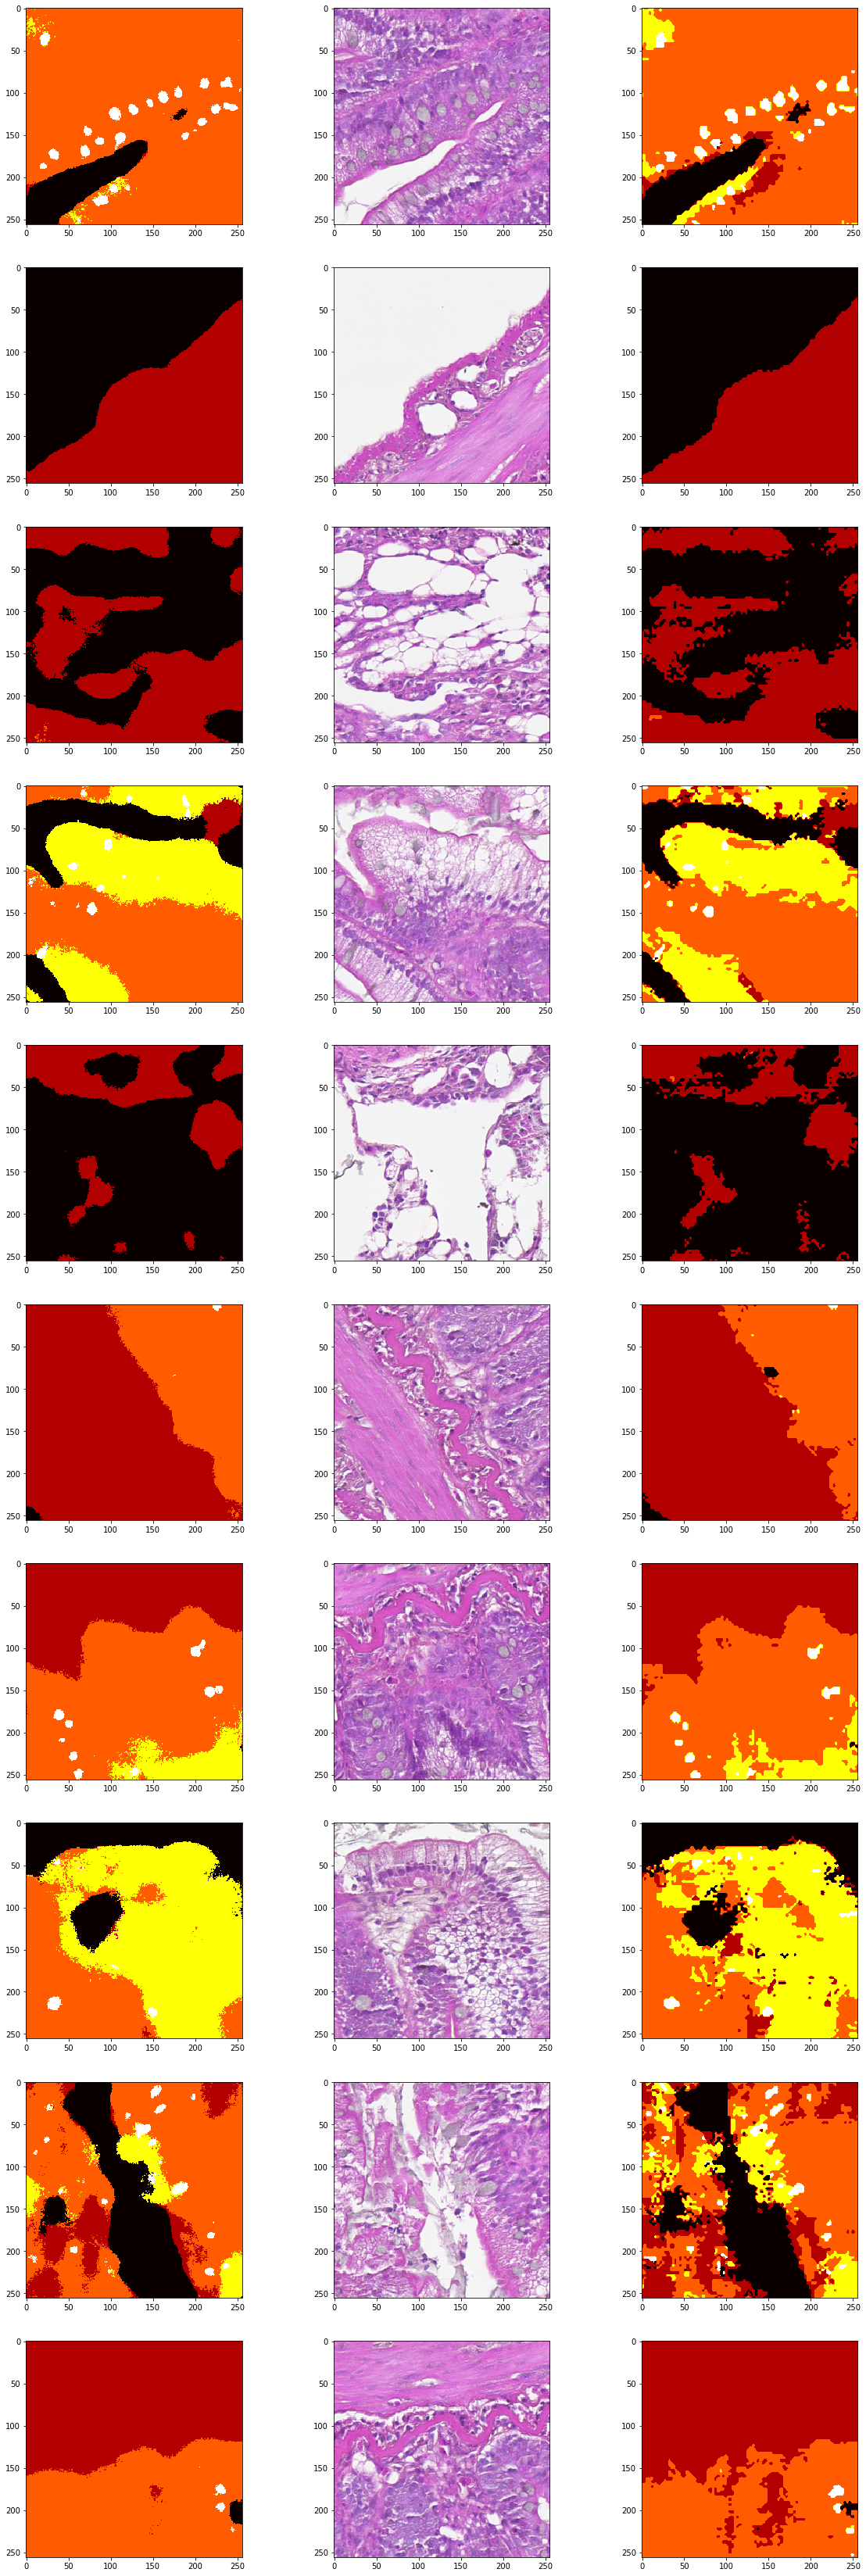

In [4]:

from matplotlib import pyplot as plt
import numpy as np
from random import choice, shuffle
from models import segnet

from keras.optimizers import SGD
opt = SGD(lr=learning_rate, decay=learning_rate / epochs)

s=MultiSegNetImage(origs,masks=masks,frame=size,overlay=overl,batchSize=batchsize)

model=segnet(
        s.getShape(),
        5,
        kernel=3,
        pool_size=(2, 2))

if training:
    
    model.compile(loss="categorical_crossentropy", optimizer=opt,
        metrics=["categorical_accuracy"])
    
    if resume_training:
        model.load_weights(base+"/" +modelname)    

    H = model.fit_generator(s,epochs=epochs)
    model.save(base+"/" + modelname)

if not training:
    
    model.load_weights(base+"/" +modelname)
    
    n_controls=10

    rs=list(range(s.images[0].total_frames))
    f, axarr = plt.subplots(n_controls,3,figsize=(20,6*n_controls))
    n=0
    
    test_ids=[]
    test_images=[]
    
    while n < n_controls:        
        i=choice(rs)
        
        orig=s.images[0].getSingleItem(i)
        
        if orig.mean() > 230:
            continue        
        test_ids += [i] 
        test_images += [orig]
        n+=1
    
    predictions=model.predict(asarray(test_images))
    
    for n,i in enumerate(test_ids):
        predicted=predictions[n].reshape((size,size,5))
        axarr[n][0].imshow(np.argmax(predicted,axis=2),vmax=4,vmin=0,cmap='hot')
        axarr[n][1].imshow(test_images[n])
        axarr[n][2].imshow(np.argmax(s.images[0].getMask(i),axis=2),vmax=4,vmin=0,cmap='hot')